In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import yaml
from nautilus import Sampler,Prior
from abacusnbody.hod.abacus_hod import AbacusHOD
from abacusnbody.hod.GRAND_HOD import *
from getdist import plots, MCSamples
import getdist
from scipy.stats import truncnorm

In [2]:
%matplotlib inline

# copy paste from run_nautilus code

In [7]:
class wp_Data(object):
    """
    Dummy object for calculating a likelihood
    """
    def __init__(self, data_params, HOD_params, nrpmin = 7, nrpmax = 21, npimax = 8):
        """
        Constructor of the power spectrum data
        """
        num_dens_mean = {}
        num_dens_std = {}
        for key in HOD_params['tracer_flags'].keys():
            if HOD_params['tracer_flags'][key]:
                num_dens_mean[key] = data_params['tracer_density_mean'][key]
                num_dens_std[key] = data_params['tracer_density_std'][key]
        self.num_dens_mean = num_dens_mean
        self.num_dens_std = num_dens_std

        rpfac = 2
        nbinrp = int(48/rpfac)
        # load the power spectrum for all tracer combinations
        clustering = {}
        wpstds = {}
        rs = {}
        for key in data_params['tracer_combos'].keys():
            clustering[key] = np.loadtxt(data_params['tracer_combos'][key]['path2wp'])[nrpmin:nrpmax, 1] # wp
            wpstds[key] = np.loadtxt(data_params['tracer_combos'][key]['path2wp'])[nrpmin:nrpmax, 2] # wp
            rs[key] = np.loadtxt(data_params['tracer_combos'][key]['path2wp'])[nrpmin:nrpmax, 0]
        self.clustering = clustering
        self.wpstds = wpstds
        self.rs = rs

        if 'path2cov' in data_params['tracer_combos'][key]:
            # load the covariance matrix for all tracer combinations
            cov = {}
            icov = {}
            for key in data_params['tracer_combos'].keys():

                newcov = np.load(data_params['tracer_combos'][key]['path2cov'])['cov']
                rescale = data_params['tracer_combos'][key].get('rescale', True)
                if rescale:
                    rescaledcov = np.zeros(newcov.shape)

                    for i in range(newcov.shape[0]):
                        for j in range(newcov.shape[1]):
                            rescaledcov[i, j] = newcov[i, j]/np.sqrt(newcov[i, i]*newcov[j, j])*wpstds[key][i]*wpstds[key][j]
                    cov[key] = rescaledcov
                else:
                    cov[key] = newcov
                
                icov[key] = np.linalg.inv(cov[key])
            self.icov = icov
            self.cov = cov


    def compute_likelihood(self, theory_clustering, theory_density, mockcov = False, ic_down = 1, jointcov_inv = None, fullscale = True):
        """
        Computes the likelihood using information from the context
        """
        skiprp = 0
        if not fullscale:
            skiprp = 4
            
        lnprob = 0.
        if jointcov_inv is None:
            for key in self.clustering.keys():
                delta = self.clustering[key] - theory_clustering[key][skiprp:]
                if mockcov:
                    lnprob += np.einsum('i,ij,j', delta, self.icov[key][skiprp:][skiprp:], delta)
                else:
                    lnprob += np.sum(delta**2/self.wpstds[key]**2)
        else:
            delta = np.concatenate([self.clustering[key] - theory_clustering[key][skiprp:] for key in np.sort(list(self.clustering.keys()))])
            lnprob += np.einsum('i,ij,j', delta, jointcov_inv, delta)
#        print(delta)
        lnprob *= -0.5

        # likelihood due to number density
        for etracer in self.num_dens_mean.keys():
            lnprob += -0.5*((self.num_dens_mean[etracer] - theory_density[etracer]*ic_down)/self.num_dens_std[etracer])**2

        print(" <><> Likelihood evaluated, lnprob = ",lnprob)
        return lnprob
    
def loglike(p, sim_params, HOD_params, clustering_params, param_mapping, mytracers, Data, nthread, bounds, mockcov, jointcov_inv, fullscale):

    if loaded_ball is None:
        print('loading data')
    Ball = load_abacus_hod_once(sim_params, HOD_params, clustering_params)
#    print("evaulating ", p)
    for tracer_type in mytracers: 
        for key in param_mapping[tracer_type].keys():
            mapping_idx = param_mapping[tracer_type][key]
            if key == 'logsigma':
                Ball.tracers[tracer_type]['sigma'] = 10**p[mapping_idx].item()
            else:
                Ball.tracers[tracer_type][key] = p[mapping_idx].item()

    # impose Mmin cut (remove unphysical HOD, help chains to converge)
    for tracer_type in mytracers: 
        if tracer_type == 'LRG' and 10**Ball.tracers[tracer_type]['logM_cut']*Ball.tracers[tracer_type]['kappa'] < 1e12:
#            print("LRG Mmin < 1e12")
            return -np.inf
        elif tracer_type == 'ELG' and N_cen_ELG_v1(2e11, Ball.tracers[tracer_type]['p_max'], 
                                                   Ball.tracers[tracer_type]['Q'], 
                                                   Ball.tracers[tracer_type]['logM_cut'], 
                                                   Ball.tracers[tracer_type]['sigma'], 
                                                   Ball.tracers[tracer_type]['gamma']) > 0.01:
#            print("ELG N(2e11) > 0.01")
            return -np.inf
        elif tracer_type == 'QSO' and 10**Ball.tracers[tracer_type]['logM_cut']*Ball.tracers[tracer_type]['kappa'] < 2e11:
#            print("QSO Mmn < 2e11")
            return -np.inf

    # we need to determine the expected number density 
    for tracer_type in mytracers:
        Ball.tracers[tracer_type]['ic'] = 1

    ngal_dict, fsat_dict = Ball.compute_ngal(Nthread = nthread)

    for tracer_type in mytracers:
        if fsat_dict[tracer_type] > 0.6:
            return -np.inf
        if not tracer_type == 'ELG':
            N_tracer = ngal_dict[tracer_type]
            Ball.tracers[tracer_type]['ic'] = \
                min(1, Data.num_dens_mean[tracer_type]*Ball.params['Lbox']**3/N_tracer)
        if tracer_type == 'ELG':
            N_tracer = ngal_dict[tracer_type]
            if abs(Data.num_dens_mean[tracer_type]*Ball.params['Lbox']**3/N_tracer - 1) > 1:
                return -np.inf

    mock_dict = Ball.run_hod(Ball.tracers, Ball.want_rsd, Nthread = nthread, verbose = False)

    # put a satellite fraction cut
    theory_density = {}
    for tracer_type in mytracers:
        if mock_dict[tracer_type]['Ncent'] < 0.4*len(mock_dict[tracer_type]['x']):
            print(tracer_type, 'fsat > 0.6')
            return -np.inf
        theory_density[tracer_type] = len(mock_dict[tracer_type]['x'])/Ball.params['Lbox']**3

    clustering = Ball.compute_wp(mock_dict, Ball.rpbins, Ball.pimax, Ball.pi_bin_size, Nthread = nthread)

    lnP = Data.compute_likelihood(clustering, theory_density, mockcov = mockcov, jointcov_inv = jointcov_inv, fullscale = fullscale)

    return lnP
    
def prepPrior(bounds):
    prior = Prior()
    for idx, bound_values in bounds:
        if len(bound_values) == 2:  # Flat prior: [lower, upper]
            lower, upper = bound_values
            prior.add_parameter(dist='flat', lower=lower, upper=upper)
        elif len(bound_values) == 4:  # Truncated normal: [lower, upper, mean, std]
            lower, upper, mean, std = bound_values
            a, b = (lower - mean) / std, (upper - mean) / std
            prior.add_parameter(dist=truncnorm(a, b, loc=mean, scale=std))
    return prior

# read all config in, maybe too much, just for convenience

In [8]:
config = yaml.safe_load(open('configs/run_QSO_GCcomb_0.8_2.1_pip_angular_bitwise_v1.4pip_zheng07.yaml'))
sim_params = config['sim_params']
HOD_params = config['HOD_params']
clustering_params = config['clustering_params']   
data_params = config['data_params']
fit_config_params = config['fit_config_params']
fit_params = config['fit_params']  

mockcov = fit_config_params.get('mockcov', False)
if mockcov:
    fit_config_params['chainsPrefix'] += '_mockcov'
jointcov = fit_config_params.get('joint', False)
jointcov_inv = None
if jointcov:
#        fit_config_params['chainsPrefix'] += '_jointmockcov'
    jointcov_inv = np.linalg.inv(np.loadtxt(jointcov))

fullscale = fit_config_params.get('fullscale', True)
# read data parameters
if fullscale:
    nrpmin = 3
else:
    nrpmin = 7
newData = wp_Data(data_params, HOD_params, nrpmin = nrpmin)

prefix_check = fit_config_params['path2output']+fit_config_params['chainsPrefix']+'.hdf5'

nparams = sum(len(v) for v in fit_params.values())
param_mapping = {}
bounds = []
mytracers = []

for tracertype, params in fit_params.items():
    mytracers.append(tracertype)
    param_mapping[tracertype] = {}
    for param, values in params.items():
        mapping_idx = values[0]
        param_mapping[tracertype][param] = mapping_idx
        # Store the entire value array, with the type inferred by the length
        bounds.append((mapping_idx, values[1:]))
bounds.sort()
prior=prepPrior(bounds)

# read abacushod object, could take a while

In [26]:
ball_q0821 = AbacusHOD(sim_params, HOD_params, clustering_params)

# Samples and triangle plot from getdist

In [3]:
chaindir = '/pscratch/sd/h/hanyuz/Y1HOD/chains/'

In [5]:
name = ['lgmc','lgm1','sigma','alpha','kappa']
label = [r'\log M_\mathrm{cut}',r'\log M_1', r'\sigma', r'\alpha', r'\kappa']

In [14]:
range_q={'lgmc':(bounds[0][1][0],bounds[0][1][1]),
         'lgm1':(bounds[1][1][0],bounds[1][1][1]),
         'sigma':(bounds[2][1][0],bounds[2][1][1]),
         'alpha':(bounds[3][1][0],bounds[3][1][1]),
         'kappa':(bounds[4][1][0],bounds[4][1][1])
         }

In [4]:
q0821 = np.loadtxt(chaindir+'chain_QSO_GCcomb_0.8_2.1_pip_angular_bitwise_v1.4pip_converged.txt')
q0821_samp=q0821[:,:5]
q0821_logw=q0821[:,5]
q0821_logl=q0821[:,6]

In [19]:
samp_q0821=MCSamples(samples=q0821_samp, 
                     weights=np.exp(q0821_logw), 
                     loglikes=q0821_logl,
                     names=name, 
                     labels=label,
                     ranges=range_q,
                     #settings={'smooth_scale_2D':-1, 'smooth_scale_1D':-1} uncomment if you want gaussian smooth
                    )

Removed no burn in


In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot([samp_q0821], filled=True, legend_labels=['z0.8~2.1 @ z1.4'])
g.export('/global/homes/h/hanyuz/Y1HOD/plots/forPre/tri_qso_0821.png')

In [ ]:
print(samp_q0821.getMargeStats()) ## note that other parameters like fsat, blin need to recalcul

# convergence check, https://nautilus-sampler.readthedocs.io/en/latest/discussion/convergence.html

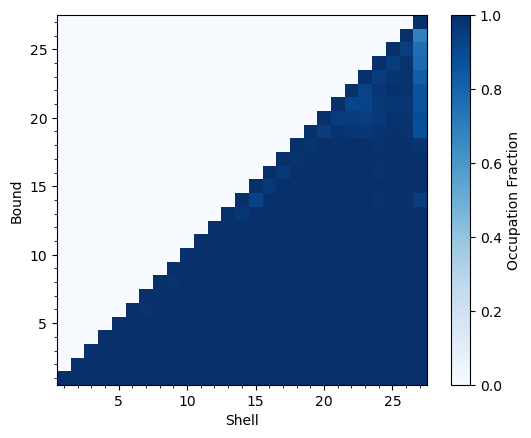

In [39]:
occ = sampler.shell_bound_occupation()

plt.imshow(occ.T, origin='lower', cmap='Blues',
           extent=(0.5, len(occ) + 0.5, 0.5, len(occ) + 0.5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xlabel('Shell')
plt.ylabel('Bound')
cb = plt.colorbar()
cb.set_label('Occupation Fraction')

# Linear Bias

In [21]:
from cosmoprimo.fiducial import DESI
from cosmoprimo import Fourier
from scipy.optimize import leastsq

In [22]:
cosmo=DESI()
fo = Fourier(cosmo, engine='class')
pk = fo.pk_interpolator()
xi_lin = pk.to_xi()

In [23]:
def getBias(xi0,z):
    xilin=xi_lin(sbinsmid,z=z)
    biasofs=np.sqrt(xi0/xilin)
    def residuals(c,x):
        return x-c
    bias,flag=leastsq(residuals,2,args=(biasofs))
    return bias[0]

In [24]:
def assignHOD(HODparams,samp):
    HODparams['QSO_params']['logM_cut']=samp[0]
    HODparams['QSO_params']['logM1']=samp[1]
    HODparams['QSO_params']['sigma']=samp[2]
    HODparams['QSO_params']['alpha']=samp[3]
    HODparams['QSO_params']['kappa']=samp[4]

In [27]:
bin_params = clustering_params['bin_params']
rpbins = np.logspace(bin_params['logmin'], bin_params['logmax'], bin_params['nbins']+1)
pimax = clustering_params['pimax']
pi_bin_size = clustering_params['pi_bin_size']
rpbinsmid=(rpbins[1:]+rpbins[:-1])/2

###smu setting###
###note that linear bias value depends on the choice of sbins, we take 40~80 as an example###
nsbins=40
mumax=1.0
nmubins=100
sbins=np.linspace(40.,80.,nsbins+1)
sbinsmid=(sbins[1:]+sbins[:-1])/2
mubins=np.linspace(0,mumax,nmubins+1)
dmu=mumax/nmubins

In [32]:
assignHOD(HOD_params,q0821_samp[np.argmax(q0821_logl)])
mocktmp = ball_q0821.run_hod(want_rsd = True, Nthread = 256,write_to_disk=False)
bf_wp_q0821 = ball_q0821.compute_multipole(mocktmp, rpbins, pimax, sbins, 100, Nthread = 256,orders=[0])['QSO_QSO'][:18]
mocktmp = ball_q0821.run_hod(want_rsd = False, Nthread = 256,write_to_disk=False)
bf_xi0_real_q0821 = ball_q0821.compute_multipole(mocktmp, rpbins, pimax, sbins, 100, Nthread = 256,orders=[0])['QSO_QSO'][18:]

In [ ]:
getBias(bf_xi0_real_q0821,1.49) #1.49 is the effective redshift

In [34]:
q0821_2nd=[12.2, 14.7, 0.12, 0.8, 0.6] #second gen value as and example

In [35]:
assignHOD(HOD_params,q0821_2nd)
mocktmp = ball_q0821.run_hod(want_rsd = True, Nthread = 256,write_to_disk=False)
edr_wp_q0821 = ball_q0821.compute_multipole(mocktmp, rpbins, pimax, sbins, 100, Nthread = 256,orders=[0])['QSO_QSO'][:18]
mocktmp = ball_q0821.run_hod(want_rsd = False, Nthread = 256,write_to_disk=False)
edr_xi0_real_q0821 = ball_q0821.compute_multipole(mocktmp, rpbins, pimax, sbins, 100, Nthread = 256,orders=[0])['QSO_QSO'][18:]

In [45]:
qy10821 =np.loadtxt('datas/wp_QSO_GCcomb_0.8_2.1_pip_angular_bitwise_v1.4pip.dat')[3:-3,1:3]
qedr0821=np.loadtxt('/pscratch/sd/h/hanyuz/Cori/SV3_HOD/measurements_edav1/wp/QSO_0821_wp.dat')[3:-3,1]

In [ ]:
fig, axs = plt.subplots(2,1,constrained_layout=True,sharex=True,figsize=(8,8),gridspec_kw={'height_ratios': [3, 1]})


axs[0].errorbar(rpbinsmid,rpbinsmid*qy10821[:,0],
                yerr=rpbinsmid*qy10821[:,1],
                marker='o',ls='',label='z0.8~2.1',color='black')

axs[0].plot(rpbinsmid,rpbinsmid*qedr0821,
                marker='o',ls='',label='z0.8~2.1',color='black', mfc='none')

axs[0].plot(rpbinsmid,rpbinsmid*bf_wp_q0821[:18],color='black')
axs[0].plot(rpbinsmid,rpbinsmid*edr_wp_q0821[:18],color='black',ls='--')

axs[0].set_xscale('log')
axs[0].grid(linestyle='--')
axs[1].grid(linestyle='--')

axs[0].axvline(0.1, 0,170, ls='--', color='darkgray')
    
axs[0].annotate(r'QSO'+'\n'+r'$b_\mathrm{lin}=2.25$',xy=(0.05,0.85),xycoords='axes fraction',fontsize=20)
axs[0].set_ylabel(r'$r_{\rm p} w_{\rm p}$',fontsize=20)
axs[1].set_ylabel(r'$\Delta w_{\rm p}/w_{\rm p}^{\rm Y1}$',fontsize=20)  
axs[1].set_xlabel(r'$r_{\rm p}$',fontsize=20)
axs[0].tick_params(labelsize=20)
axs[1].tick_params(labelsize=20)


axs[1].plot(rpbinsmid,(bf_wp_q0821[:18]-qy10821[:,0])/qy10821[:,0],color='black')
axs[1].fill_between(rpbinsmid,(-qy10821[:,1])/qy10821[:,0],(qy10821[:,1])/qy10821[:,0],color='lightgray')
axs[0].fill_between(x=np.linspace(rpbins[0],0.1,100),y1=0,y2=170,zorder=-1,hatch='\ ',fc='white',edgecolor='dimgray')
axs[1].fill_between(x=np.linspace(rpbins[0],0.1,100),y1=-0.2,y2=0.7,zorder=-1,hatch='\ ',fc='white',edgecolor='dimgray')

#axs[0].legend(frameon=True,fontsize=20)
#axs[1].legend(frameon=True,fontsize=20)

axs[0].set_ylim(0,170)
axs[1].set_ylim(-0.2,0.7)

axs[0].set_xlim(rpbins[0],rpbins[-3])
axs[1].plot(rpbinsmid,np.zeros_like(rpbinsmid),ls='-.',color='black')
fig.savefig('/global/homes/h/hanyuz/Y1HOD/plots/forPre/bf_QSO_0821.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)
plt.show()